# Osborne Mine and Lightning Creek Sill Complex aeromagnetic data

This is a section of a survey acquired in 1990 by the Queensland Government, Australia. The data are good quality with approximately 80 m terrain clearance and 200 m line spacing. The section contains the total field magnetic anomalies associated with the Osborne Mine, Lightning Creek sill complex, and the Brumby prospect. 

> **WARNING**: This notebook required \~9 Gb of RAM to run. The dataset is a bit large (\~3 Gb on disk and ~90 million points) and the GA provided netCDF file is not very useful for out-of-memory indexing since the latitude and longitude aren't properly set as coordinates. 

License: [CC-BY](http://pid.geoscience.gov.au/dataset/ga/142419)

Original source: Geophysical Acquisition & Processing Section 2019. MIM Data from Mt Isa Inlier, QLD (P1029), magnetic line data, AWAGS levelled. Geoscience Australia, Canberra. http://pid.geoscience.gov.au/dataset/ga/142419

Useful references for prior interpretations and geological context:

* [Austin, et al. (2013)](https://doi.org/10.1190/INT-2013-0005.1)
* [Gazley et al. (2016)](https://publications.csiro.au/rpr/download?pid=csiro:EP165511&dsid=DS2)
* [Rezaie (2021)](https://doi.org/10.1007/s00024-021-02747-6)
* [Elllis et al. (2019)](https://doi.org/10.1071/ASEG2012ab117)
* [Perring et al. (2000)](https://doi.org/10.2113/gsecongeo.95.5.1067)

In [1]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import pygmt
import pyproj
import verde as vd
import pooch

## Download the data archive

Use Pooch to download the data archive provided by Geoscience Australia in netCDF format.

In [2]:
fname = pooch.retrieve(
    url="http://dapds00.nci.org.au/thredds/fileServer/iv65/Geoscience_Australia_Geophysics_Reference_Data_Collection/airborne_geophysics/QLD/line/P1029/P1029-line-magnetic-AWAGS_MAG_2010.nc",
    known_hash="sha256:119b472da05365f0df4e9dc0b2d4b0e5c213705acb4f79efcaa07e1aeeb7242c",
)

Check the file size in Mb just so we know what we're dealing with.

In [3]:
print(f"size: {os.path.getsize(fname) / 1e6 : 7.2f} Mb")

size:  3096.63 Mb


## Load the data

That's around 3 Gb of data (likely compressed) so it's best to open the `xarray.Dataset` without reading everything into memory at once (as `xarray.load_dataset` would do).

In [4]:
data_nc = xr.open_dataset(fname)
data_nc

<xarray.Dataset>
Dimensions:            (point: 96100603, line: 11231)
Coordinates:
  * line               (line) float64 1.0 2.0 3.0 ... 1.123e+04 1.123e+04
Dimensions without coordinates: point
Data variables: (12/14)
    line_index         (point) float64 ...
    areaFlag           (line) float32 ...
    levelFlag          (line) float64 ...
    lineType           (line) float64 ...
    FID                (point) float64 ...
    altitude           (point) float64 ...
    ...                 ...
    mag_awagsLevelled  (point) float32 ...
    mag_microLevelled  (point) float32 ...
    mag_tieLevelled    (point) float64 ...
    latitude           (point) float64 ...
    longitude          (point) float64 ...
    crs                int8 ...
Attributes: (12/23)
    CreationTime:             Sun Dec 15 23:09:37 2019
    CreationMethod:           intrepid2netcdf.exe
    IntrepidSourceDataset:    ./mag_database_reformat_adjusted/intrepid/GSQP1...
    median_sample_spacing_m:  6.7
    geospatial_bounds:        POLYGON ((138.000707 -18.061092, 138.000733 -18...
    geospatial_lon_max:       141.34279740678033
    ...                       ...
    institution:              Commonwealth of Australia (Geoscience Australia)
    uuid:                     12ee23de-033c-44f2-8b63-932203d25f39
    Conventions:              CF-1.6, ACDD-1.3
    metadata_link:            http://pid.geoscience.gov.au/dataset/ga/142419
    keywords:                 AWAGS, Australia, Earth sciences, GADDS2.0, QLD...
    licence:                  CC BY 4.0 (C) Commonwealth of Australia (Geosci...

The fields we're interested in are:

* Coordinates which are in the GDA94 datum
* AWAGS leveled magnetic anomaly (since the observed field values aren't present)
* The terrain clearance (which is what I'm assuming `altitude` is since it can't be observation height)
* The line number in case we need to group points by line

We'll read these fields only into a `pandas.DataFrame` for easier slicing.

In [5]:
data_full = pd.DataFrame({
    "longitude": data_nc.longitude.data,
    "latitude": data_nc.latitude.data,
    "terrain_clearance_m": data_nc.altitude.data.astype(np.float32),
    "total_field_anomaly_nt": data_nc.mag_awagsLevelled.data.astype(np.float32),
    "flight_line": data_nc.line_index.data.astype(np.uint16),
})

Cut the survey to a smaller region containing only the anomalies we want.

In [8]:
srtm = vd.grid_to_table(pygmt.grdcut("@earth_relief_01s_g", region=vd.pad_region(region, 2 / 60)))
srtm

,lat,lon,z
0,-22.200000,140.466667,294.0
1,-22.200000,140.466944,294.0
2,-22.200000,140.467222,295.0
3,-22.200000,140.467500,295.0
4,-22.200000,140.467778,294.0
...,...,...,...
2508776,-21.716667,140.865556,346.0
2508777,-21.716667,140.865833,350.0
2508778,-21.716667,140.866111,356.0
2508779,-21.716667,140.866389,359.0


## Convert the horizontal coordinates

Now that we have less data, we can convert the coordinates into WGS84 for uniformity with our other datasets. 

In [7]:
gda_to_wgs = pyproj.Transformer.from_crs("epsg:4283", "epsg:4326", always_xy=True)
longitude, latitude = gda_to_wgs.transform(
    data.longitude.values, 
    data.latitude.values,
)
data = data.assign(longitude=longitude, latitude=latitude)
data

,longitude,latitude,terrain_clearance_m,total_field_anomaly_nt,flight_line
0,140.664111,-21.868325,80.699997,-124.284653,5576
1,140.664025,-21.868325,80.599998,-124.181824,5576
2,140.663940,-21.868325,80.599998,-124.069214,5576
3,140.663855,-21.868325,80.500000,-123.946846,5576
4,140.663769,-21.868324,80.400002,-123.834244,5576
...,...,...,...,...,...
990982,140.507573,-21.870226,79.269997,-66.726227,10166
990983,140.507574,-21.870285,79.400002,-66.385582,10166
990984,140.507575,-21.870344,79.580002,-66.055672,10166
990985,140.507576,-21.870398,79.790001,-65.685265,10166


## Get topographic height

The data only contain the terrain clearance information, so we won't know the height of observations unless we know the height of topography. 

We can use PyGMT to get a high-resolution grid of SRTM topography (as orthometric height) and then interpolate the values onto our data locations. We'll get a slightly larger grid than our data region to avoid edge effects during interpolation.

In [8]:
srtm = vd.grid_to_table(pygmt.grdcut("@earth_relief_01s_g", region=vd.pad_region(region, 2 / 60)))
srtm

,lat,lon,z
0,-22.200000,140.466667,294.0
1,-22.200000,140.466944,294.0
2,-22.200000,140.467222,295.0
3,-22.200000,140.467500,295.0
4,-22.200000,140.467778,294.0
...,...,...,...
2508776,-21.716667,140.865556,346.0
2508777,-21.716667,140.865833,350.0
2508778,-21.716667,140.866111,356.0
2508779,-21.716667,140.866389,359.0


Now that we have the topography, we'll do the interpolation using a fast nearest-neighbor method. Since we only have access to a Cartesian version of the interpolation, we need to first project the input coordinates (using a Mercator projection here).

In [9]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

nearest = vd.ScipyGridder(method="nearest")
nearest.fit(projection(srtm.lon.values, srtm.lat.values), srtm.z)

data = data.assign(
    topography_srtm_sea_level_m=nearest.predict(projection(data.longitude.values, data.latitude.values))
)
data

,longitude,latitude,terrain_clearance_m,total_field_anomaly_nt,flight_line,topography_srtm_sea_level_m
0,140.664111,-21.868325,80.699997,-124.284653,5576,286.0
1,140.664025,-21.868325,80.599998,-124.181824,5576,286.0
2,140.663940,-21.868325,80.599998,-124.069214,5576,286.0
3,140.663855,-21.868325,80.500000,-123.946846,5576,286.0
4,140.663769,-21.868324,80.400002,-123.834244,5576,286.0
...,...,...,...,...,...,...
990982,140.507573,-21.870226,79.269997,-66.726227,10166,303.0
990983,140.507574,-21.870285,79.400002,-66.385582,10166,303.0
990984,140.507575,-21.870344,79.580002,-66.055672,10166,303.0
990985,140.507576,-21.870398,79.790001,-65.685265,10166,303.0


## Inspect the data

Make a quick plot of the data to see what it looks like. We'll use a blocked median filter to reduce the data size a bit for plotting.

In [10]:
spacing = 3 / 3600
reducer = vd.BlockReduce(np.median, spacing=spacing)
coordinates, total_field_anomaly = reducer.filter((data.longitude, data.latitude), data.total_field_anomaly_nt)

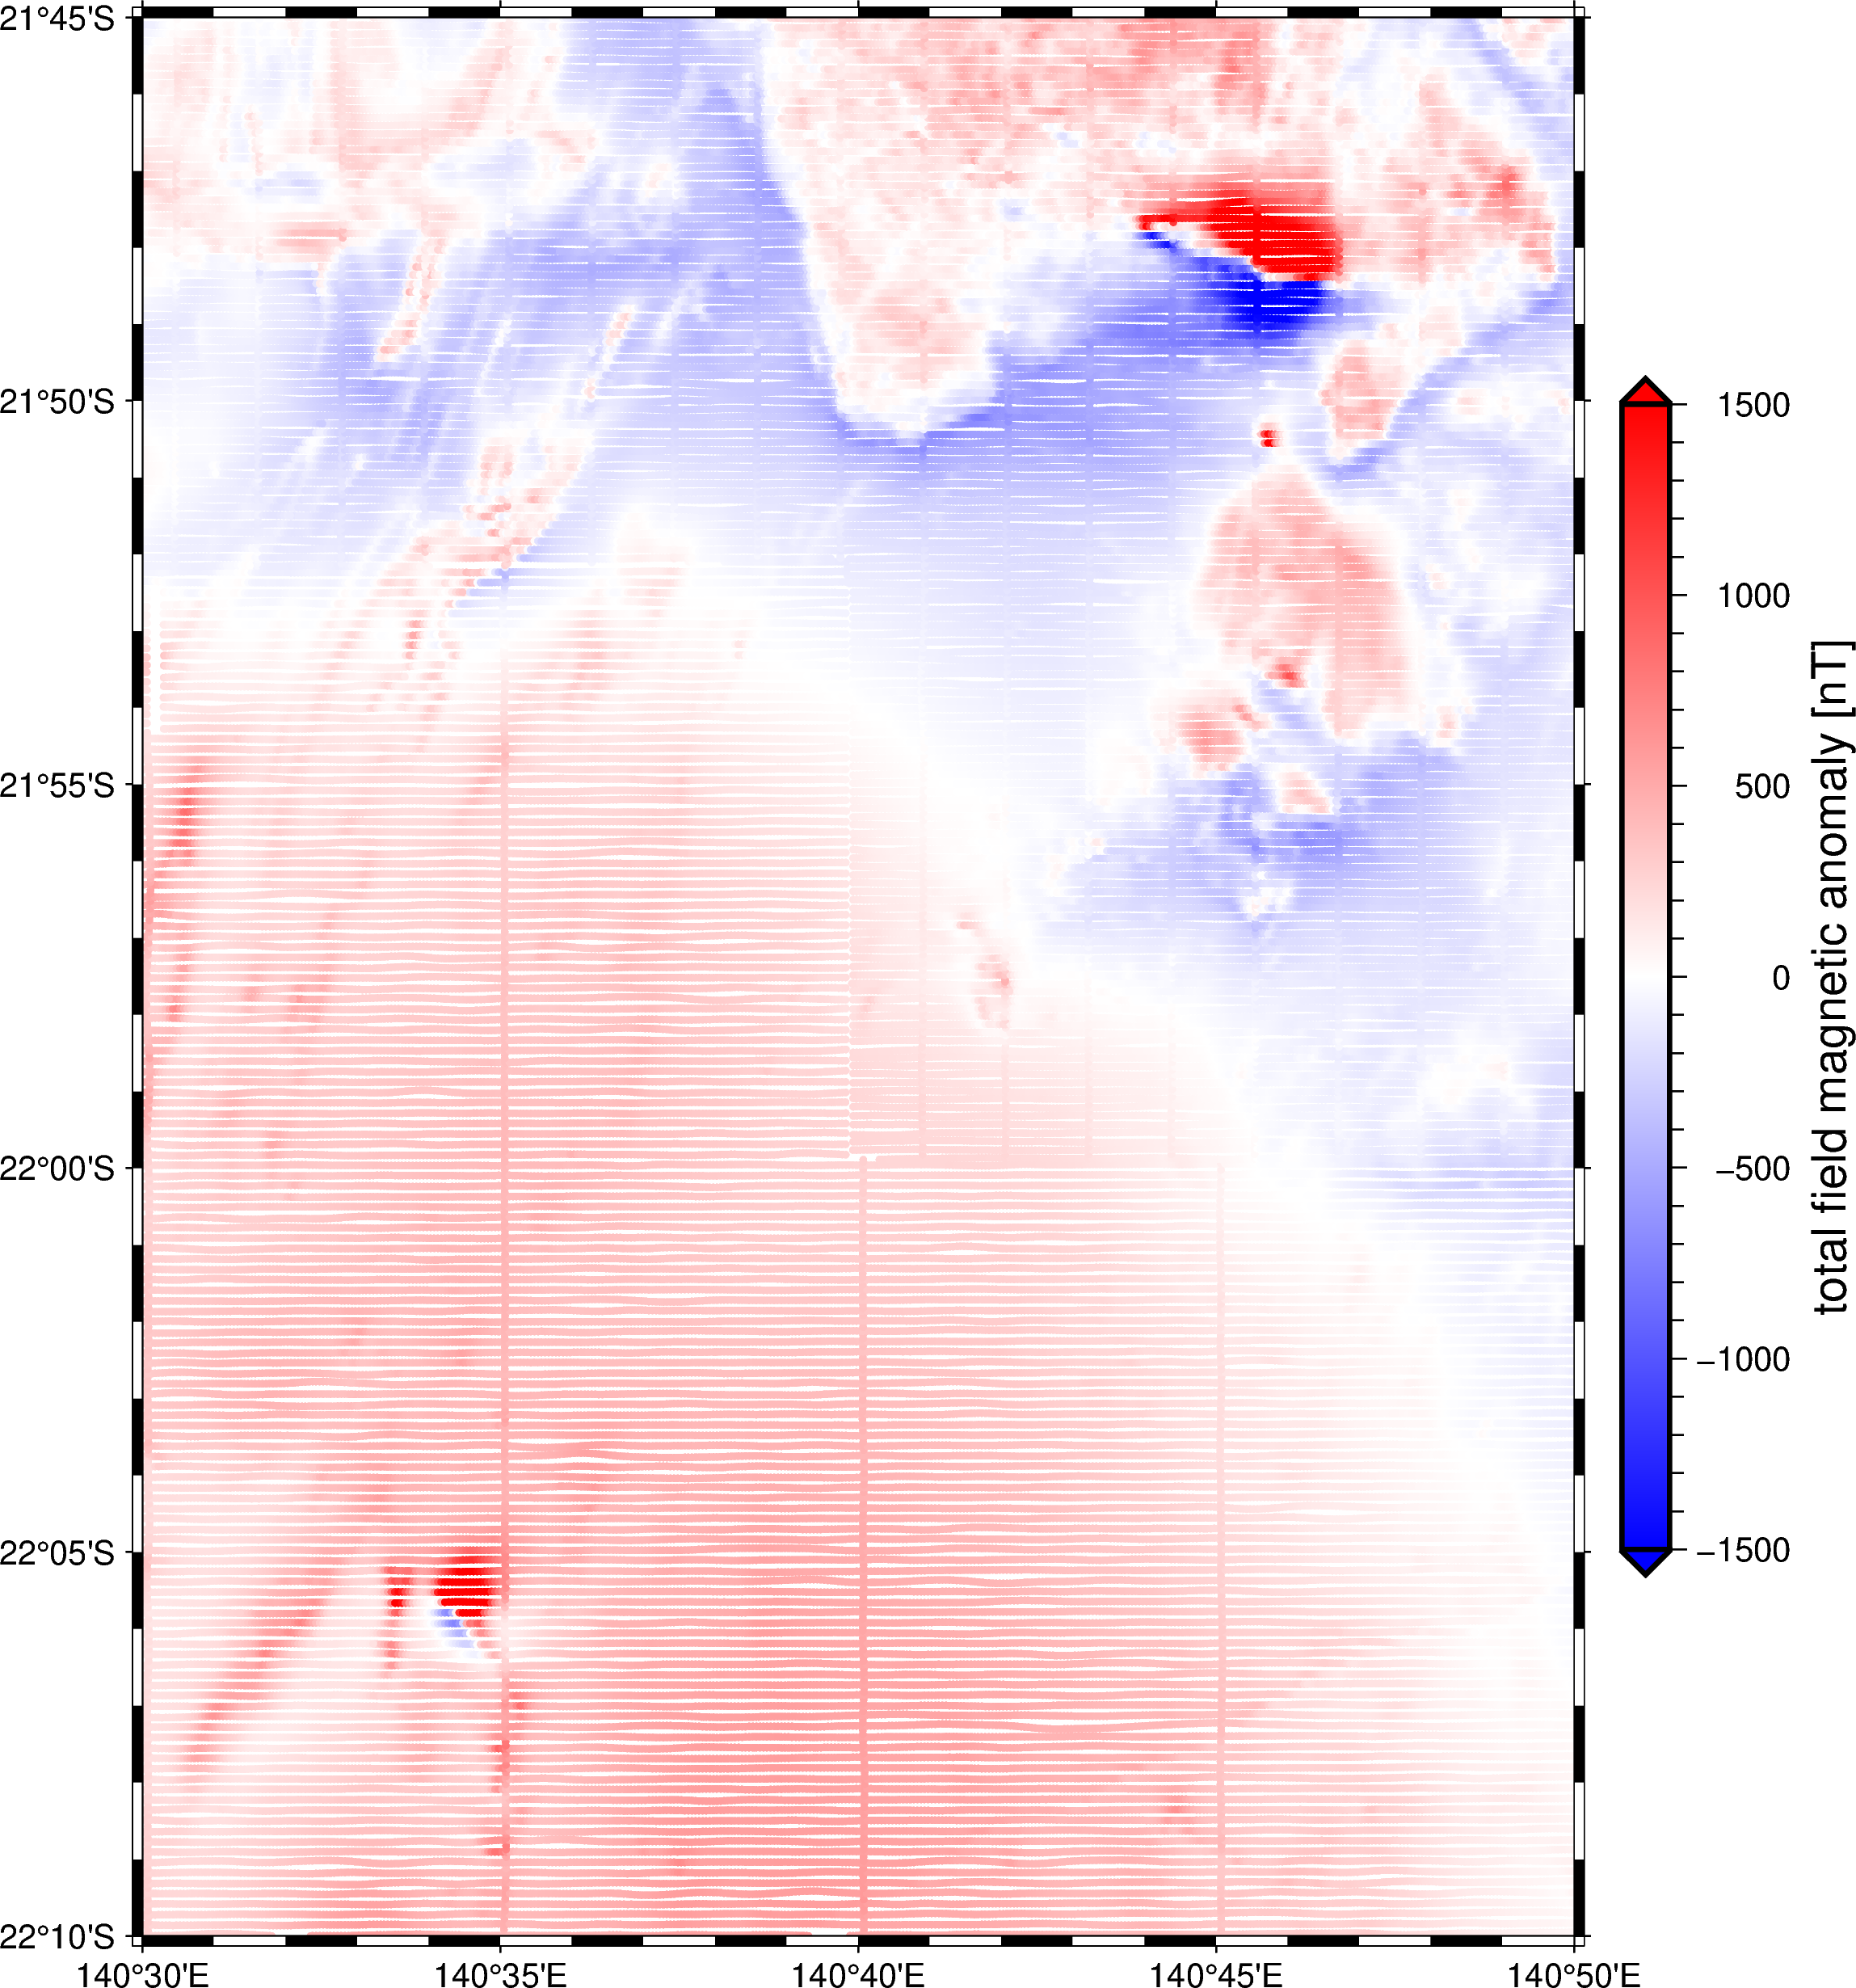

In [11]:
fig = pygmt.Figure()
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.plot(
    x=coordinates[0],
    y=coordinates[1],
    projection="M15c",
    region=region,
    color=total_field_anomaly,
    style="c0.075c",
    cmap=True,
)
fig.colorbar(
    frame='af+l"total field magnetic anomaly [nT]"', 
    position="JCR+v+w12c/0.5c+o0.5c/0+e",
)
fig.basemap(frame="af")
fig.savefig("preview.jpg", dpi=200)
fig.show()

The Osborne Mine is the small dipolar anomaly in the Southwest of the map. The Lightning Creek complex is the large anomaly in the Northeast.

## Export

Save the data to a compressed CSV file for easier loading with pandas directly. We'll first make a string encoded version of the `DataFrame` so we can control the precision of the output and save some storage space. For our purposes, 1 m precision should be more than enough for coordinates and topography and 1 nT for the magnetic anomaly (~0.1% of the anomaly amplitudes).

In [12]:
export = pd.DataFrame({  
    "flight_line": data.flight_line, 
    "longitude": data.longitude.map(lambda x: "{:.5f}".format(x)),
    "latitude": data.latitude.map(lambda x: "{:.5f}".format(x)),    
    "terrain_clearance_m": data.terrain_clearance_m.map(lambda x: "{:.0f}".format(x)),   
    "topography_srtm_sea_level_m": data.topography_srtm_sea_level_m.map(lambda x: "{:.0f}".format(x)),   
    "total_field_anomaly_nt": data.total_field_anomaly_nt.map(lambda x: "{:.0f}".format(x)), 
})
export

,flight_line,longitude,latitude,terrain_clearance_m,topography_srtm_sea_level_m,total_field_anomaly_nt
0,5576,140.66411,-21.86833,81,286,-124
1,5576,140.66403,-21.86832,81,286,-124
2,5576,140.66394,-21.86832,81,286,-124
3,5576,140.66385,-21.86832,80,286,-124
4,5576,140.66377,-21.86832,80,286,-124
...,...,...,...,...,...,...
990982,10166,140.50757,-21.87023,79,303,-67
990983,10166,140.50757,-21.87029,79,303,-66
990984,10166,140.50758,-21.87034,80,303,-66
990985,10166,140.50758,-21.87040,80,303,-66


Save the export data and calculate the file size and hashes.

In [13]:
fname = "osborne-magnetic.csv.xz"
export.to_csv(fname, index=False)
print(fname)
print(f"size: {os.path.getsize(fname) / 1e6} Mb")
for alg in ["md5", "sha256"]:
    print(f"{alg}:{pooch.file_hash(fname, alg=alg)}")

osborne-magnetic.csv.xz
size: 2.289052 Mb
md5:542abd2d3571c9a07718b83ebda0343c
sha256:06d657e2ccad4873aa0fb55bdea594a9695b2e6ca2460a56be7a2e893f7ada53


## Read the data back

To check that everything worked well, read the data back and make a plot.

In [14]:
data_back = pd.read_csv(fname)
data_back

,flight_line,longitude,latitude,terrain_clearance_m,topography_srtm_sea_level_m,total_field_anomaly_nt
0,5576,140.66411,-21.86833,81,286,-124
1,5576,140.66403,-21.86832,81,286,-124
2,5576,140.66394,-21.86832,81,286,-124
3,5576,140.66385,-21.86832,80,286,-124
4,5576,140.66377,-21.86832,80,286,-124
...,...,...,...,...,...,...
990982,10166,140.50757,-21.87023,79,303,-67
990983,10166,140.50757,-21.87029,79,303,-66
990984,10166,140.50758,-21.87034,80,303,-66
990985,10166,140.50758,-21.87040,80,303,-66


In [15]:
coordinates, total_field_anomaly = reducer.filter(
    (data_back.longitude, data_back.latitude), 
    data_back.total_field_anomaly_nt,
)

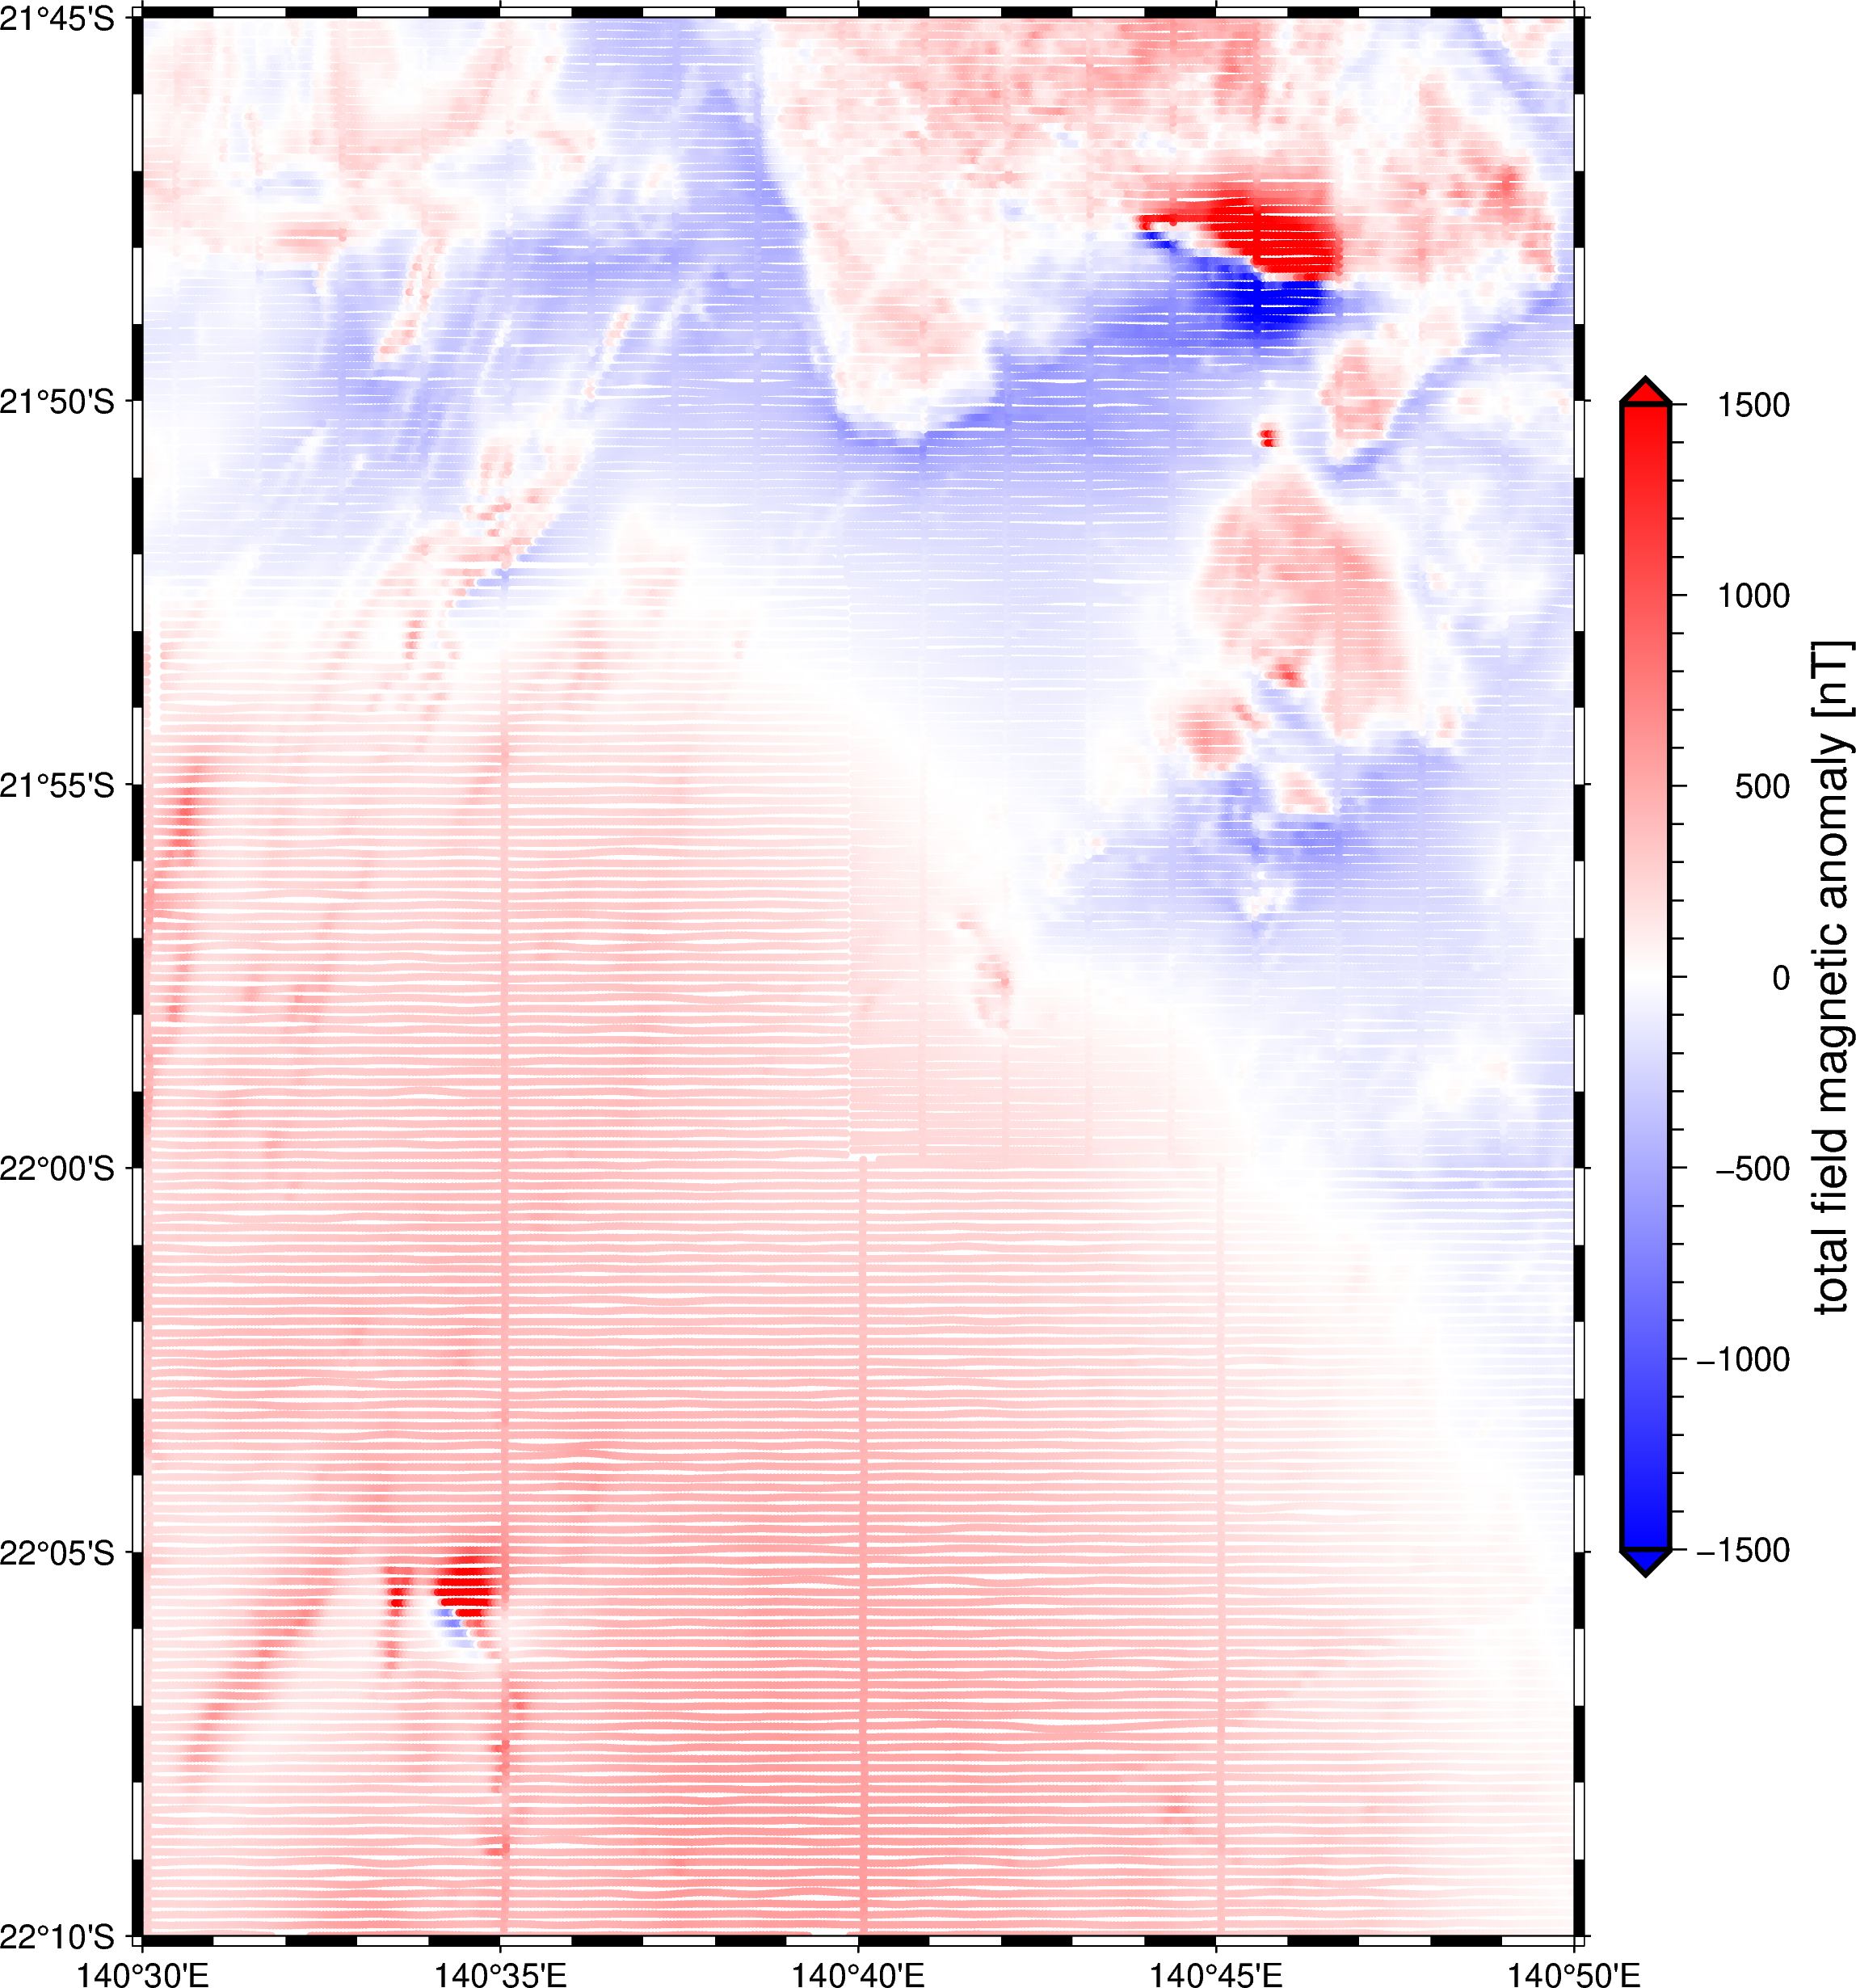

In [16]:
fig = pygmt.Figure()
scale = 1500
pygmt.makecpt(cmap="polar+h", series=[-scale, scale], background=True)
fig.plot(
    x=coordinates[0],
    y=coordinates[1],
    projection="M15c",
    region=region,
    color=total_field_anomaly,
    style="c0.075c",
    cmap=True,
)
fig.colorbar(
    frame='af+l"total field magnetic anomaly [nT]"', 
    position="JCR+v+w12c/0.5c+o0.5c/0+e",
)
fig.basemap(frame="af")
fig.show()